# Market Basket analysis

In [36]:
import numpy as np
import pandas as pd


# Small toy Dataset

In [37]:
sm = {"t_1": ["A", "C", "D"], "t_2":["B", "C", "E"], "t_3":["A", "B", "C", "E"], "t_4":["B", "E"]}
sm_dict = {"t_1":[1, 1, 1, 0, 0], "t_2":[1, 0, 1, 0, 0], "t_3":[1, 0, 1, 1, 0], "t_4":[1, 0, 0, 0, 1], 't_5':[0,0,0,1,1] }
sm_df1 = pd.DataFrame(sm_dict)
sm_df1 = sm_df1.T
sm_df1.columns = ["A", "B", "C", "D", "E"]
sm_df1

,A,B,C,D,E
t_1,1,1,1,0,0
t_2,1,0,1,0,0
t_3,1,0,1,1,0
t_4,1,0,0,0,1
t_5,0,0,0,1,1


In [69]:
def itemset_support(df, itemset):
    items = df.columns
    n = df.shape[0]
    count = 0
    itemset = set(itemset)
    for basket in df.iterrows():
        basket_inds = basket[1].to_numpy().nonzero()
        basket_items = set(items[basket_inds])
        if itemset.issubset(basket_items):
            count +=1
    return count/n

def find_itemsets(df):
    """
    takes in dataset with purchases as one hot encoded vectors.
    converts to booleans - much faster
    iterates though, looks for repeated themes
    """
    cols = df.columns
    bt = df.apply(lambda x: x > 0, raw=True)
    bt = bt.apply(lambda x: set(cols[x.values]), axis=1)
    return bt

    
itemsets = find_itemsets(sm_df1)

itemsets

t_1    {A, B, C}
t_2       {A, C}
t_3    {D, A, C}
t_4       {A, E}
t_5       {D, E}
dtype: object

In [71]:
# L1 large 1 itemsets
for item in sm_df1.columns:
    support = itemset_support(sm_df1, item)
    print(item, support)

A 0.8
B 0.2
C 0.6
D 0.4
E 0.4


In [72]:
def get_L1(df, min_support):
    itemset=[]
    supports = []
    for item in df.columns:
        support = itemset_support(df, item)
#         print(item, support)
        if support >= min_support:
            itemset.append(set(item))
            supports.append(support)
    return itemset, supports


# Own implementation

In [73]:
# Apriori algorithm - Agrawal and Srikant 


def find_subsets(array):
    """ finds all subsets length one less than the array"""
    subs = []
    for member in array:
        sub = set(member)^array
        subs.append(sub)
    return subs
    
def apriori(df, min_support):
    """
    generates large 1-itemsets
    finds those with at least min_support
    looks to see if those can be combined with other large 1-itemsets
    """
    bt = find_itemsets(df) # makes sets out of transations
    L1, supports = get_L1(df, min_support)
    k=1
    Lk=L1
    df = pd.DataFrame(zip(L1,supports), columns =['Itemsets', 'Support'])
    while len(Lk)!=0:
        c_k = apriori_gen(Lk, k+1)
        counts = np.zeros(len(c_k))
#         print(c_k)
        for trans in bt:
            for ind in range(len(c_k)):
#                 print(trans, c_k[ind], c_k[ind].issubset(trans), counts)
                if c_k[ind].issubset(trans):
#                     print(c_k[ind])
                    counts[ind]+=1
        supports = counts/len(bt)
#         print(supports, counts, len(bt))
        Lk = [c_k[i] for i in range(len(c_k)) if supports[i]>min_support]
        row = [(c_k[i], supports[i]) for i in range(len(c_k)) if supports[i]>min_support]
#         print(row)
        row = pd.DataFrame(row, columns =['Itemsets', 'Support'])
        df = pd.concat([df,row], ignore_index=True)
        k+=1
    
    return df
        
def apriori_gen(L, i):
    """
    takes list of posisble sets with length i-1 L
    looks to see what combinations of those are possible to make list of candidate sets with
    length i
    """
    cand_lst = []
    for set_K in L:
        # try with every other member
        notK = [x for x in L if x!=set_K]
        for set_J in notK:
            kuj = set_K.union(set_J)
            if len(kuj)==i and kuj not in cand_lst:
                kujsubs = find_subsets(kuj)
                can_work=1
                for sub in kujsubs:
                    if sub not in L:
                        can_work=0
                if can_work:
                    cand_lst.append(kuj)
        L = notK
    return cand_lst
        


def check_support(df, itemset_lst, min_support):
    cand_lst = []
    for itemset in itemset_lst:
        sup = itemset_support(df, itemset)
        print(itemset, sup)
        if sup >=min_support:
            cand_lst.append(itemset)
    return cand_lst


In [74]:
apriori(sm_df1, 0.5)

,Itemsets,Support
0,{A},0.8
1,{C},0.6
2,"{A, C}",0.6


In [43]:
sm = {"t_1": ["A", "C", "D"], "t_2":["B", "C", "E"], "t_3":["A", "B", "C", "E"], "t_4":["B", "E"]}
sm_dict = {"t_1":[1, 0, 1, 1, 0], "t_2":[0, 1, 1, 0, 1], "t_3":[1, 1, 1, 0, 1], "t_4":[0, 1, 0, 0, 1] }
sm_df2 = pd.DataFrame(sm_dict)
sm_df2 = sm_df2.T
sm_df2.columns = ["A", "B", "C", "D", "E"]
sm_df2

,A,B,C,D,E
t_1,1,0,1,1,0
t_2,0,1,1,0,1
t_3,1,1,1,0,1
t_4,0,1,0,0,1


In [44]:
apriori(sm_df2, 0.4)

,Itemsets,Support
0,{A},0.50
1,{B},0.75
2,{C},0.75
3,{E},0.75
4,"{A, C}",0.50
5,"{B, C}",0.50
6,"{B, E}",0.75
7,"{C, E}",0.50
8,"{B, C, E}",0.50


# test with library implementation

In [77]:
from mlxtend.frequent_patterns import apriori, association_rules

apriori(sm_df1, min_support=0.4, use_colnames=True)

,support,itemsets
0,0.8,(A)
1,0.6,(C)
2,0.4,(D)
3,0.4,(E)
4,0.6,"(A, C)"


In [78]:
apriori(sm_df2, min_support=0.5, use_colnames=True)

,support,itemsets
0,0.50,(A)
1,0.75,(B)
2,0.75,(C)
3,0.75,(E)
4,0.50,"(A, C)"
5,0.50,"(B, C)"
6,0.75,"(B, E)"
7,0.50,"(C, E)"
8,0.50,"(B, C, E)"


# Rules, Confidence

In [79]:
def get_rule_confidence(x, y, df):
    """ look for rule x=>y confidence"""
    bt = find_itemsets(df) # makes sets out of transations
    x_count = 0
    xy_count=0
    for trans in bt:
        if x.issubset(trans):
            x_count+=1
            if y.issubset(trans):
                xy_count+=1
    return xy_count/x_count
            

In [80]:
def get_rules(df, min_sup, min_conf):
    rules = []
    ap_df = apriori(df, min_support=min_sup, use_colnames=True)
    for itemset in ap_df.itemsets:
        if len(itemset)<2:
            continue
        for member in itemset:
            ant = set(member)
            con = ant^itemset
            conf = get_rule_confidence(ant, con, df)
            if conf>=min_conf:
                rules.append((f"{ant}=>{con}", conf))
            conf = get_rule_confidence(con, ant, df)
            if conf>=min_conf:
                rules.append((f"{con}=>{ant}", conf))
    return rules

In [81]:
get_rules(sm_df1, 0.4, 0.2)

[("{'A'}=>{'C'}", 0.75),
 ("{'C'}=>{'A'}", 1.0),
 ("{'C'}=>{'A'}", 1.0),
 ("{'A'}=>{'C'}", 0.75)]

In [82]:
get_rules(sm_df2, 0.5, 0.2)

[("{'A'}=>{'C'}", 1.0),
 ("{'C'}=>{'A'}", 0.6666666666666666),
 ("{'C'}=>{'A'}", 0.6666666666666666),
 ("{'A'}=>{'C'}", 1.0),
 ("{'B'}=>{'C'}", 0.6666666666666666),
 ("{'C'}=>{'B'}", 0.6666666666666666),
 ("{'C'}=>{'B'}", 0.6666666666666666),
 ("{'B'}=>{'C'}", 0.6666666666666666),
 ("{'B'}=>{'E'}", 1.0),
 ("{'E'}=>{'B'}", 1.0),
 ("{'E'}=>{'B'}", 1.0),
 ("{'B'}=>{'E'}", 1.0),
 ("{'C'}=>{'E'}", 0.6666666666666666),
 ("{'E'}=>{'C'}", 0.6666666666666666),
 ("{'E'}=>{'C'}", 0.6666666666666666),
 ("{'C'}=>{'E'}", 0.6666666666666666),
 ("{'B'}=>{'C', 'E'}", 0.6666666666666666),
 ("{'C', 'E'}=>{'B'}", 1.0),
 ("{'C'}=>{'B', 'E'}", 0.6666666666666666),
 ("{'B', 'E'}=>{'C'}", 0.6666666666666666),
 ("{'E'}=>{'B', 'C'}", 0.6666666666666666),
 ("{'B', 'C'}=>{'E'}", 1.0)]

Compare with library functions

In [88]:
freq_itemsets = apriori(sm_df1, min_support=0.4, use_colnames=True)
association_rules(freq_itemsets, metric="confidence", min_threshold=0.7)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(A),(C),0.8,0.6,0.6,0.75,1.25,0.12,1.6
1,(C),(A),0.6,0.8,0.6,1.00,1.25,0.12,inf


In [90]:
freq_itemsets = apriori(sm_df2, min_support=0.5, use_colnames=True)
association_rules(freq_itemsets, metric="confidence", min_threshold=0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(A),(C),0.50,0.75,0.50,1.000000,1.333333,0.1250,inf
1,(C),(A),0.75,0.50,0.50,0.666667,1.333333,0.1250,1.50
2,(B),(C),0.75,0.75,0.50,0.666667,0.888889,-0.0625,0.75
3,(C),(B),0.75,0.75,0.50,0.666667,0.888889,-0.0625,0.75
4,(B),(E),0.75,0.75,0.75,1.000000,1.333333,0.1875,inf
5,(E),(B),0.75,0.75,0.75,1.000000,1.333333,0.1875,inf
6,(C),(E),0.75,0.75,0.50,0.666667,0.888889,-0.0625,0.75
7,(E),(C),0.75,0.75,0.50,0.666667,0.888889,-0.0625,0.75
8,"(B, C)",(E),0.50,0.75,0.50,1.000000,1.333333,0.1250,inf
9,"(B, E)",(C),0.75,0.75,0.50,0.666667,0.888889,-0.0625,0.75


# Different measures


 ## Lift

In [85]:
def get_lift(x, y, df):
    conf = get_rule_confidence(x, y, df)
    bt = find_itemsets(df) # makes sets out of transations
    y_count = 0
    for trans in bt:
        if y.issubset(trans):
            y_count+=1
    py = y_count/len(bt)
    return conf/py

In [86]:
get_lift({'A'}, {'C'}, sm_df1)

1.25

In [87]:
get_lift({'C'}, {'A'}, sm_df1)

1.25

In [91]:
get_lift({'C'}, {'A'}, sm_df2)

1.3333333333333333

In [92]:
get_lift({'A'}, {'C'}, sm_df2)

1.3333333333333333

## Conviction

In [96]:
def conviction(x, y, df):
    bt = find_itemsets(df) # makes sets out of transactions
    xnoty_count = 0
    y_count = 0
    noty_count=0
    x_count=0
    for trans in bt:
        if x.issubset(trans):
            x_count+=1
        if y.issubset(trans):
            y_count+=1
        else:
            if x.issubset(trans):
                xnoty_count+=1
    pnoty = (len(bt)-y_count)/len(bt)
    px =x_count/len(bt)
    pxnoty=xnoty_count/len(bt)
    if pxnoty ==0:
        return 'inf'
    
    return (px*pnoty)/pxnoty

In [97]:
conviction({'A'}, {'C'}, sm_df1)

1.6000000000000003

In [98]:
conviction({'C'}, {'A'}, sm_df1)

'inf'

In [99]:
conviction({'A'}, {'C'}, sm_df2)

'inf'

In [100]:
conviction({'C'}, {'A'}, sm_df2)

1.5

# Larger data set

In [101]:
df = pd.read_csv("wholesaleRetail.csv")
df.info()
t_id = df["InvoiceNo"]
item = df["StockCode"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65499 entries, 0 to 65498
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    65499 non-null  object 
 1   StockCode    65499 non-null  object 
 2   Description  65333 non-null  object 
 3   Quantity     65499 non-null  int64  
 4   InvoiceDate  65499 non-null  object 
 5   UnitPrice    65499 non-null  float64
 6   CustomerID   40218 non-null  float64
 7   Country      65499 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 4.0+ MB


In [102]:
transaction_database = (df
          .groupby(['InvoiceNo', 'StockCode'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
transaction_database.info()
t_d = transaction_database

<class 'pandas.core.frame.DataFrame'>
Index: 2888 entries, 536365 to C541694
Columns: 2973 entries, 10002 to m
dtypes: float64(2973)
memory usage: 65.5+ MB


In [103]:
#transaction_database.drop(['amazon', 'POSTAGE','amazon sales','counted','check','damages', "faulty", "found", "mouldy, thrown away.", "reverse 21/5/10 adjustment"], inplace=True, axis=1)
transaction_database.drop(['DOT', 'M','POST','gift_0001_20','gift_0001_30','gift_0001_40', "gift_0001_50", "m", 'AMAZONFEE', 'BANK CHARGES', 'C2', 'D','S'], inplace=True, axis=1)

In [131]:
t_d

StockCode,10002,10120,10123C,10124A,10124G,10125,10133,10135,11001,15034,...,90214R,90214S,90214T,90214V,90214W,90214Y,90214Z,DCGS0003,DCGS0070,DCGS0076
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C541688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C541689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C541691,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


drop transactions with only one item

In [129]:
row_sum = t_d.astype(bool).sum(axis=1)
# print(row_sum.index)
td = t_d.drop([x for x in row_sum.index if row_sum[x]<2])

Index(['536365', '536366', '536367', '536368', '536369', '536370', '536371',
       '536372', '536373', '536374',
       ...
       'C541651', 'C541653', 'C541654', 'C541656', 'C541674', 'C541688',
       'C541689', 'C541691', 'C541693', 'C541694'],
      dtype='object', name='InvoiceNo', length=2888)


In [130]:
td

StockCode,10002,10120,10123C,10124A,10124G,10125,10133,10135,11001,15034,...,90214R,90214S,90214T,90214V,90214W,90214Y,90214Z,DCGS0003,DCGS0070,DCGS0076
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536370,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
541686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
541690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
t_dict = {}
items = t_d.columns
for row in t_d.iterrows():
    t_id=row[0]
    basket = row[1]
    basket_inds = basket.to_numpy().nonzero()
    basket_items = set(items[basket_inds])
    t_dict[t_id] = basket_items



In [133]:

#get set L_i
min_sup = 0.01
items = t_d.columns
sups = []
L_1 = []
for item in items:
    
    sup = itemset_support(t_d, [item])
    sups.append(sup)
    if sup > min_sup:
        L_1.append(item)

In [134]:
print(len(L_1))

742


In [135]:
print(np.mean(sups))
print(np.std(sups))
print(np.max(sups))
print(np.min(sups))

0.007348440892415961
0.009330177114980907
0.11565096952908588
0.0


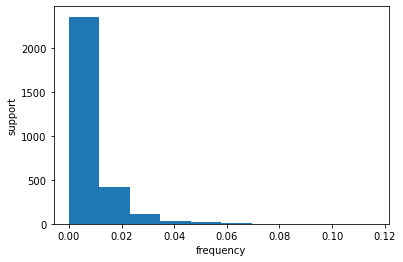

In [136]:
import matplotlib.pyplot as plt
plt.xlabel('frequency')
plt.ylabel('support')
plt.hist(sups);

In [142]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
t_d = t_d.applymap(encode_units)

# lost information about quantity - does it matter?


In [143]:
freq_itemsets = apriori(t_d, min_support=min_sup, use_colnames=True)

In [144]:

association_lst = [x for x in freq_itemsets.itemsets if len(x) >1]

association_itemsets = freq_itemsets[freq_itemsets.itemsets.apply(lambda x: len(x)>1)]

In [145]:
association_itemsets

,support,itemsets
742,0.011427,"(10135, 20717)"
743,0.010042,"(10135, 20866)"
744,0.012465,"(10135, 21110)"
745,0.010734,"(10135, 21494)"
746,0.010734,"(10135, 21773)"
...,...,...
8013,0.010042,"(21803, 22161, 21992, 21801, 21935, 85131D, 21..."
8014,0.010042,"(21803, 22162, 21992, 21801, 21935, 22834, 21802)"
8015,0.010042,"(21803, 21992, 21801, 21935, 22834, 85131D, 21..."
8016,0.010042,"(21992, 21801, 21935, 21846, 22834, 21802, 21934)"


In [146]:
len(association_itemsets)

7276

In [147]:
sizes = [len(x) for x in association_lst]

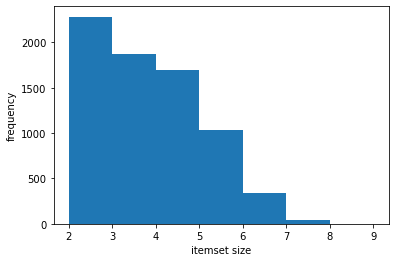

In [148]:
plt.xlabel('itemset size')
plt.ylabel('frequency')
plt.hist(sizes, [2,3,4,5,6,7,8,9]);